**Forecasting NO2, O3, HCHO from year worth of NASA TEMPO data**

In [23]:
import pandas as pd
df = pd.read_csv("/content/tempo_till_june.csv")

In [24]:
df.describe()

,Unnamed: 0,o3_column_amount_o3(DU),no2_vertical_column_total(molecules/cm2),vertical_column(molecules/cm2)
count,135.0,329.000000,3.290000e+02,3.290000e+02
mean,0.0,334.355158,1.123884e+16,1.219535e+16
std,0.0,39.621534,4.421302e+15,1.105953e+16
min,0.0,237.758804,3.919330e+15,6.198400e+13
25%,0.0,310.434457,8.350360e+15,5.112530e+15
50%,0.0,328.604251,1.040000e+16,9.722510e+15
75%,0.0,358.481473,1.300000e+16,1.650000e+16
max,0.0,469.340644,3.520000e+16,1.050000e+17


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 5 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                135 non-null    float64
 1   o3_column_amount_o3(DU)                   329 non-null    float64
 2   no2_vertical_column_total(molecules/cm2)  329 non-null    float64
 3   vertical_column(molecules/cm2)            329 non-null    float64
 4   Day                                       329 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.0+ KB


In [26]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import pickle
import os
warnings.filterwarnings('ignore')

# **Data Pre-Processing:**

In [27]:

def prepare_data(df):
    """Clean and prepare the dataframe for forecasting"""
    df_clean = df.copy()

    # Drop the Unnamed: 0 column if it exists
    if 'Unnamed: 0' in df_clean.columns:
        df_clean = df_clean.drop('Unnamed: 0', axis=1)

    # Convert Day to datetime and set as index
    df_clean['Day'] = pd.to_datetime(df_clean['Day'])
    df_clean = df_clean.set_index('Day').sort_index()

    return df_clean

def create_comprehensive_features(df, target_col, lags=14, rolling_windows=[7, 14, 30]):

    features_df = df.copy()

    print(f"  Creating features for {len(df)} days of data...")

    # Create lagged features for all columns
    for col in df.columns:
        for lag in range(1, lags + 1):
            features_df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # Create rolling statistics
    for col in df.columns:
        for window in rolling_windows:
            features_df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
            features_df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
            features_df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
            features_df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()

    # Create seasonal and time-based features
    features_df['day_of_year'] = features_df.index.dayofyear
    features_df['day_of_week'] = features_df.index.dayofweek
    features_df['week_of_year'] = features_df.index.isocalendar().week
    features_df['month'] = features_df.index.month
    features_df['quarter'] = features_df.index.quarter
    features_df['is_weekend'] = (features_df.index.dayofweek >= 5).astype(int)

    # Seasonal features
    features_df['sin_day_of_year'] = np.sin(2 * np.pi * features_df.index.dayofyear / 365.25)
    features_df['cos_day_of_year'] = np.cos(2 * np.pi * features_df.index.dayofyear / 365.25)
    features_df['sin_month'] = np.sin(2 * np.pi * features_df.index.month / 12)
    features_df['cos_month'] = np.cos(2 * np.pi * features_df.index.month / 12)

    # Rate of change features
    for col in df.columns:
        features_df[f'{col}_daily_change'] = df[col].diff()
        features_df[f'{col}_weekly_change'] = df[col].diff(7)

    # Drop initial rows with NaN values
    initial_count = len(features_df)
    features_df = features_df.dropna()
    final_count = len(features_df)

    print(f"  Feature creation complete: {initial_count} → {final_count} samples")
    print(f"  Total features: {len(features_df.columns) - 1}")  # Excluding target

    return features_df

In [28]:
def save_model_and_scaler(model, scaler, target_col, model_dir='saved_models'):
    """Save model and scaler to pickle files"""
    try:
        # Create directory if it doesn't exist - FIXED THIS PART
        os.makedirs(model_dir, exist_ok=True)

        # Clean the target_col name for filename safety
        safe_target_col = "".join(c for c in target_col if c.isalnum() or c in (' ', '_', '-')).rstrip()

        # Save model
        model_filename = os.path.join(model_dir, f'{safe_target_col}_model.pkl')
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)

        # Save scaler
        scaler_filename = os.path.join(model_dir, f'{safe_target_col}_scaler.pkl')
        with open(scaler_filename, 'wb') as f:
            pickle.dump(scaler, f)

        print(f"  ✅ Saved {target_col} model and scaler to {model_dir}/")
        return True
    except Exception as e:
        print(f"  ❌ Error saving {target_col} model and scaler: {e}")
        return False

# **Forecasting Model using RandomForest:**

In [29]:
def analyze_trends(df):
    """Analyze trends and patterns in the data"""
    print("\n" + "="*60)
    print("📈 TREND ANALYSIS")
    print("="*60)

    for col in df.columns:
        print(f"\n{col}:")

        # Basic statistics
        data = df[col]
        print(f"  Period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
        print(f"  Mean: {data.mean():.4f}")
        print(f"  Std:  {data.std():.4f}")
        print(f"  Min:  {data.min():.4f}")
        print(f"  Max:  {data.max():.4f}")

        # Trend analysis
        x = np.arange(len(data))
        trend_coef = np.polyfit(x, data, 1)[0]
        trend_per_day = trend_coef
        trend_per_month = trend_coef * 30

        print(f"  Daily trend: {trend_per_day:+.6f} units/day")
        print(f"  Monthly trend: {trend_per_month:+.6f} units/month")

        # Seasonal analysis (weekly pattern)
        weekly_avg = data.groupby(data.index.dayofweek).mean()
        if len(weekly_avg) == 7:
            max_day = weekly_avg.idxmax()
            min_day = weekly_avg.idxmin()
            days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
            print(f"  Weekly pattern - Highest: {days[max_day]}, Lowest: {days[min_day]}")

        # Recent vs historical
        recent_avg = data.tail(7).mean()
        historical_avg = data.mean()
        change_pct = ((recent_avg - historical_avg) / historical_avg) * 100
        print(f"  Recent vs Historical: {change_pct:+.1f}%")


In [30]:
def forecast_all_parameters_comprehensive(df, forecast_days=7, save_models=True):
    """Comprehensive forecasting for all parameters"""

    df_clean = prepare_data(df)

    print("AIR QUALITY PARAMETERS FORECASTING")
    print("=" * 70)
    print(f"Dataset: {len(df_clean)} days ({df_clean.index.min().strftime('%Y-%m-%d')} to {df_clean.index.max().strftime('%Y-%m-%d')})")
    print(f"Parameters: {df_clean.columns.tolist()}")
    print(f"Forecasting: Next {forecast_days} days")
    if save_models:
        print("Models and scalers will be saved to 'saved_models/' directory")
    print("=" * 70)

    # First, analyze the data
    analyze_trends(df_clean)

    forecasts = {}
    performance = {}
    feature_importances = {}

    for target_col in df_clean.columns:
        print(f"\nFORECASTING: {target_col}")
        print("-" * 60)

        future_pred, perf_metrics, feat_importance = forecast_parameter_robust(
            df_clean, target_col, forecast_days, save_models=save_models
        )
        forecasts[target_col] = future_pred
        performance[target_col] = perf_metrics
        feature_importances[target_col] = feat_importance

        print(f"Model Performance:")
        print(f"  MAE:  {perf_metrics['MAE']:.4f}")
        print(f"  RMSE: {perf_metrics['RMSE']:.4f}")
        print(f"  R²:   {perf_metrics['R2']:.4f}")

    return forecasts, performance, feature_importances

In [31]:
def load_model_and_scaler(target_col, model_dir='saved_models'):

    try:
        # Clean the target_col name for filename safety
        safe_target_col = "".join(c for c in target_col if c.isalnum() or c in (' ', '_', '-')).rstrip()

        # Load model
        model_filename = os.path.join(model_dir, f'{safe_target_col}_model.pkl')
        with open(model_filename, 'rb') as f:
            model = pickle.load(f)

        # Load scaler
        scaler_filename = os.path.join(model_dir, f'{safe_target_col}_scaler.pkl')
        with open(scaler_filename, 'rb') as f:
            scaler = pickle.load(f)

        print(f"  ✅ Loaded {target_col} model and scaler from {model_dir}/")
        return model, scaler
    except FileNotFoundError:
        print(f"  ❌ Model or scaler for {target_col} not found in {model_dir}/")
        return None, None
    except Exception as e:
        print(f"  ❌ Error loading {target_col} model and scaler: {e}")
        return None, None


In [32]:
def forecast_parameter_robust(df, target_col, forecast_days=7, save_models=True):
    """Robust forecasting for parameters with 5 months of data"""

    # Create comprehensive features
    features_df = create_comprehensive_features(df, target_col)

    if len(features_df) < 30:
        print(f"  ⚠️  Warning: Only {len(features_df)} samples available after feature creation")

    # Prepare features (exclude target and its first lag)
    feature_cols = [col for col in features_df.columns
                   if col != target_col and not col.startswith(f'{target_col}_lag_1')]

    X = features_df[feature_cols]
    y = features_df[target_col]

    print(f"  Feature matrix shape: {X.shape}")

    # Split data: last 30 days for testing
    split_idx = len(X) - 30
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"  Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train robust model
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)

    # Save model and scaler if requested
    if save_models:
        save_model_and_scaler(model, scaler, target_col)

    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = model.score(X_test_scaled, y_test)

    # Feature importance (top 10)
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    print(f"  Top 5 important features:")
    for _, row in feature_importance.head().iterrows():
        print(f"    {row['feature']}: {row['importance']:.4f}")

    # Forecast future values
    future_predictions = []
    current_features = X.iloc[-1:].copy()

    for day in range(forecast_days):
        # Scale and predict
        current_scaled = scaler.transform(current_features)
        pred = model.predict(current_scaled)[0]
        future_predictions.append(pred)

        print(f"  Day {day+1} forecast: {pred:.4f}" if pred < 1e6 else f"  Day {day+1} forecast: {pred:.4e}")

        # Update features for next prediction
        if day < forecast_days - 1:
            new_row = current_features.copy()

            # Update lagged features
            for col in df.columns:
                # Shift all lags
                for lag in range(14, 1, -1):
                    lag_col = f'{col}_lag_{lag}'
                    prev_lag_col = f'{col}_lag_{lag-1}'
                    if lag_col in new_row.columns and prev_lag_col in new_row.columns:
                        new_row[lag_col] = new_row[prev_lag_col].values[0]

                # Update lag 1
                lag_1_col = f'{col}_lag_1'
                if lag_1_col in new_row.columns:
                    if col == target_col:
                        new_row[lag_1_col] = pred
                    else:
                        # For other parameters, use most recent value
                        new_row[lag_1_col] = df[col].iloc[-1]

            # Update rolling statistics (simplified - use recent values)
            # Update time features
            next_date = df.index[-1] + pd.Timedelta(days=day+1)
            time_features = {
                'day_of_year': next_date.dayofyear,
                'day_of_week': next_date.dayofweek,
                'week_of_year': next_date.isocalendar().week,
                'month': next_date.month,
                'quarter': next_date.quarter,
                'is_weekend': 1 if next_date.dayofweek >= 5 else 0,
                'sin_day_of_year': np.sin(2 * np.pi * next_date.dayofyear / 365.25),
                'cos_day_of_year': np.cos(2 * np.pi * next_date.dayofyear / 365.25),
                'sin_month': np.sin(2 * np.pi * next_date.month / 12),
                'cos_month': np.cos(2 * np.pi * next_date.month / 12)
            }

            for feature, value in time_features.items():
                if feature in new_row.columns:
                    new_row[feature] = value

            current_features = new_row

    return future_predictions, {'MAE': mae, 'RMSE': rmse, 'R2': r2}, feature_importance





# Execute comprehensive forecasting
print("Initializing comprehensive forecasting system...")
forecasts, performance, feature_importances = forecast_all_parameters_comprehensive(
    df, forecast_days=7, save_models=True
)

# Display final results
print("\n" + "=" * 70)
print(" FINAL FORECAST RESULTS")
print("=" * 70)

last_date = pd.to_datetime(df['Day']).max()
forecast_dates = [last_date + pd.Timedelta(days=i+1) for i in range(7)]

for i, date in enumerate(forecast_dates):
    print(f"\n{date.strftime('%Y-%m-%d %A')}:")
    for param, values in forecasts.items():
        value = values[i]
        if abs(value) > 1e6:
            print(f"  {param}: {value:.4e}")
        else:
            print(f"  {param}: {value:.4f}")

# Create forecast dataframe
forecast_df = pd.DataFrame(forecasts, index=forecast_dates)
forecast_df.index.name = 'Day'

print("\n" + "=" * 70)
print("FORECAST DATAFRAME")
print("=" * 70)
print(forecast_df)

print("\n" + "=" * 70)
print("FORECAST CONFIDENCE ASSESSMENT")
print("=" * 70)
print(f"With 1 year of data (365+ days), 7-day forecasts should be reasonably reliable.")
print("The models capture seasonal patterns and weekly cycles effectively.")

# Save forecasts to CSV
forecast_df.to_csv('air_quality_forecasts_7days.csv')
print("\n7-day forecasts saved to 'air_quality_forecasts_7days.csv'")

# Additional: Create a summary of the 7-day forecast trends
print("\n" + "=" * 70)
print("7-DAY FORECAST TREND SUMMARY")
print("=" * 70)

for param, values in forecasts.items():
    if len(values) >= 2:
        first_day = values[0]
        last_day = values[-1]
        change = last_day - first_day
        change_pct = (change / first_day) * 100 if first_day != 0 else 0

        print(f"\n{param}:")
        print(f"  Start: {first_day:.4f}" if first_day < 1e6 else f"  Start: {first_day:.4e}")
        print(f"  End:   {last_day:.4f}" if last_day < 1e6 else f"  End:   {last_day:.4e}")
        print(f"  Change: {change:+.4f}" if abs(change) < 1e6 else f"  Change: {change:+.4e}")
        print(f"  Change %: {change_pct:+.2f}%")

        # Trend direction
        if change_pct > 1:
            trend = "↗️ Increasing"
        elif change_pct < -1:
            trend = "↘️ Decreasing"
        else:
            trend = "➡️ Stable"
        print(f"  Trend: {trend}")

# Information about the saved models
print("\n" + "=" * 70)
print("MODEL SAVING INFORMATION")
print("=" * 70)
print("All models and scalers have been saved to the 'saved_models/' directory.")
print("Files created for each parameter:")
for target_col in df.columns:
    if 'Unnamed: 0' not in target_col and target_col != 'Day':
        safe_name = "".join(c for c in target_col if c.isalnum() or c in (' ', '_', '-')).rstrip()
        print(f"  - {safe_name}_model.pkl")
        print(f"  - {safe_name}_scaler.pkl")
print("\nTo load and use these models later, call:")
print("model, scaler = load_model_and_scaler('parameter_name')")

Initializing comprehensive forecasting system...
AIR QUALITY PARAMETERS FORECASTING
Dataset: 329 days (2024-01-01 to 2025-01-01)
Parameters: ['o3_column_amount_o3(DU)', 'no2_vertical_column_total(molecules/cm2)', 'vertical_column(molecules/cm2)']
Forecasting: Next 7 days
Models and scalers will be saved to 'saved_models/' directory

📈 TREND ANALYSIS

o3_column_amount_o3(DU):
  Period: 2024-01-01 to 2025-01-01
  Mean: 334.3552
  Std:  39.6215
  Min:  237.7588
  Max:  469.3406
  Daily trend: -0.173841 units/day
  Monthly trend: -5.215224 units/month
  Weekly pattern - Highest: Fri, Lowest: Mon
  Recent vs Historical: -11.1%

no2_vertical_column_total(molecules/cm2):
  Period: 2024-01-01 to 2025-01-01
  Mean: 11238838784194528.0000
  Std:  4421302393814834.0000
  Min:  3919330000000000.0000
  Max:  35200000000000000.0000
  Daily trend: +2067009677919.374268 units/day
  Monthly trend: +62010290337581.226562 units/month
  Weekly pattern - Highest: Fri, Lowest: Sun
  Recent vs Historical: +1

# **Plotting:**

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")


## Data Preparation Function

In [34]:
# Cell 2: Data Preparation Functions
def prepare_data(df):
    """Clean and prepare the dataframe for forecasting"""
    df_clean = df.copy()

    # Drop the Unnamed: 0 column if it exists
    if 'Unnamed: 0' in df_clean.columns:
        df_clean = df_clean.drop('Unnamed: 0', axis=1)

    # Convert Day to datetime and set as index
    df_clean['Day'] = pd.to_datetime(df_clean['Day'])
    df_clean = df_clean.set_index('Day').sort_index()

    return df_clean

def create_comprehensive_features(df, target_col, lags=14, rolling_windows=[7, 14, 30]):
    """Create comprehensive features for 5 months of data"""
    features_df = df.copy()

    print(f"  Creating features for {len(df)} days of data...")

    # Create lagged features for all columns
    for col in df.columns:
        for lag in range(1, lags + 1):
            features_df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # Create rolling statistics
    for col in df.columns:
        for window in rolling_windows:
            features_df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
            features_df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
            features_df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
            features_df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()

    # Create seasonal and time-based features
    features_df['day_of_year'] = features_df.index.dayofyear
    features_df['day_of_week'] = features_df.index.dayofweek
    features_df['week_of_year'] = features_df.index.isocalendar().week
    features_df['month'] = features_df.index.month
    features_df['quarter'] = features_df.index.quarter
    features_df['is_weekend'] = (features_df.index.dayofweek >= 5).astype(int)

    # Seasonal features
    features_df['sin_day_of_year'] = np.sin(2 * np.pi * features_df.index.dayofyear / 365.25)
    features_df['cos_day_of_year'] = np.cos(2 * np.pi * features_df.index.dayofyear / 365.25)
    features_df['sin_month'] = np.sin(2 * np.pi * features_df.index.month / 12)
    features_df['cos_month'] = np.cos(2 * np.pi * features_df.index.month / 12)

    # Rate of change features
    for col in df.columns:
        features_df[f'{col}_daily_change'] = df[col].diff()
        features_df[f'{col}_weekly_change'] = df[col].diff(7)

    # Drop initial rows with NaN values
    initial_count = len(features_df)
    features_df = features_df.dropna()
    final_count = len(features_df)

    print(f"  Feature creation complete: {initial_count} → {final_count} samples")
    print(f"  Total features: {len(features_df.columns) - 1}")  # Excluding target

    return features_df

## Model Saving

In [35]:
# Cell 3: Model Saving and Loading Functions
def save_model_and_scaler(model, scaler, target_col, model_dir='saved_models'):
    """Save model and scaler to pickle files"""
    try:
        # Create directory if it doesn't exist
        os.makedirs(model_dir, exist_ok=True)

        # Clean the target_col name for filename safety
        safe_target_col = "".join(c for c in target_col if c.isalnum() or c in (' ', '_', '-')).rstrip()

        # Save model
        model_filename = os.path.join(model_dir, f'{safe_target_col}_model.pkl')
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)

        # Save scaler
        scaler_filename = os.path.join(model_dir, f'{safe_target_col}_scaler.pkl')
        with open(scaler_filename, 'wb') as f:
            pickle.dump(scaler, f)

        print(f"  ✅ Saved {target_col} model and scaler to {model_dir}/")
        return True
    except Exception as e:
        print(f"  ❌ Error saving {target_col} model and scaler: {e}")
        return False

def load_model_and_scaler(target_col, model_dir='saved_models'):
    """Load saved model and scaler from pickle files"""
    try:
        # Clean the target_col name for filename safety
        safe_target_col = "".join(c for c in target_col if c.isalnum() or c in (' ', '_', '-')).rstrip()

        # Load model
        model_filename = os.path.join(model_dir, f'{safe_target_col}_model.pkl')
        with open(model_filename, 'rb') as f:
            model = pickle.load(f)

        # Load scaler
        scaler_filename = os.path.join(model_dir, f'{safe_target_col}_scaler.pkl')
        with open(scaler_filename, 'rb') as f:
            scaler = pickle.load(f)

        print(f"  ✅ Loaded {target_col} model and scaler from {model_dir}/")
        return model, scaler
    except FileNotFoundError:
        print(f"  ❌ Model or scaler for {target_col} not found in {model_dir}/")
        return None, None
    except Exception as e:
        print(f"  ❌ Error loading {target_col} model and scaler: {e}")
        return None, None

##Visualization functions

In [36]:
# Cell 4: Visualization Functions
def plot_actual_vs_predicted_with_forecast(df, target_col, forecast_days=7):
    """Create actual vs predicted plots with comprehensive analysis including forecasts"""

    df_clean = prepare_data(df)
    features_df = create_comprehensive_features(df_clean, target_col)

    # Prepare features
    feature_cols = [col for col in features_df.columns
                   if col != target_col and not col.startswith(f'{target_col}_lag_1')]

    X = features_df[feature_cols]
    y = features_df[target_col]

    # Split data (same as before)
    split_idx = len(X) - 30
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Scale and train model
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    # Get predictions for both train and test
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Generate forecasts for the next 7 days
    future_predictions = []
    current_features = X.iloc[-1:].copy()

    for day in range(forecast_days):
        current_scaled = scaler.transform(current_features)
        pred = model.predict(current_scaled)[0]
        future_predictions.append(pred)

        # Update features for next prediction
        if day < forecast_days - 1:
            new_row = current_features.copy()

            # Update lagged features
            for col in df_clean.columns:
                for lag in range(14, 1, -1):
                    lag_col = f'{col}_lag_{lag}'
                    prev_lag_col = f'{col}_lag_{lag-1}'
                    if lag_col in new_row.columns and prev_lag_col in new_row.columns:
                        new_row[lag_col] = new_row[prev_lag_col].values[0]

                lag_1_col = f'{col}_lag_1'
                if lag_1_col in new_row.columns:
                    if col == target_col:
                        new_row[lag_1_col] = pred
                    else:
                        new_row[lag_1_col] = df_clean[col].iloc[-1]

            # Update time features
            next_date = df_clean.index[-1] + pd.Timedelta(days=day+1)
            time_features = {
                'day_of_year': next_date.dayofyear,
                'day_of_week': next_date.dayofweek,
                'week_of_year': next_date.isocalendar().week,
                'month': next_date.month,
                'quarter': next_date.quarter,
                'is_weekend': 1 if next_date.dayofweek >= 5 else 0,
                'sin_day_of_year': np.sin(2 * np.pi * next_date.dayofyear / 365.25),
                'cos_day_of_year': np.cos(2 * np.pi * next_date.dayofyear / 365.25),
                'sin_month': np.sin(2 * np.pi * next_date.month / 12),
                'cos_month': np.cos(2 * np.pi * next_date.month / 12)
            }

            for feature, value in time_features.items():
                if feature in new_row.columns:
                    new_row[feature] = value

            current_features = new_row

    # Create forecast dates
    last_date = df_clean.index[-1]
    forecast_dates = [last_date + pd.Timedelta(days=i+1) for i in range(forecast_days)]

    # Create subplots with adjusted layout for forecasts
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'Actual vs Predicted with {forecast_days}-Day Forecast: {target_col}', fontsize=16, fontweight='bold')

    # Plot 1: Time Series - Actual vs Predicted with Forecast
    dates_test = y_test.index
    dates_train = y_train.index

    axes[0,0].plot(dates_train, y_train, label='Actual (Train)', alpha=0.7, linewidth=2, color='blue')
    axes[0,0].plot(dates_train, y_train_pred, label='Predicted (Train)', alpha=0.7, linestyle='--', color='lightblue')
    axes[0,0].plot(dates_test, y_test, label='Actual (Test)', alpha=0.7, linewidth=2, color='green')
    axes[0,0].plot(dates_test, y_test_pred, label='Predicted (Test)', alpha=0.7, linestyle='--', color='lightgreen')

    # Add forecast
    axes[0,0].plot(forecast_dates, future_predictions, label=f'Forecast ({forecast_days} days)',
                   alpha=0.8, linewidth=3, color='red', marker='o', markersize=4)

    axes[0,0].axvline(x=dates_test[0], color='red', linestyle=':', alpha=0.7, label='Train/Test Split')
    axes[0,0].axvline(x=last_date, color='orange', linestyle=':', alpha=0.7, label='Forecast Start')
    axes[0,0].set_title(f'Time Series: Actual vs Predicted with {forecast_days}-Day Forecast')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel(target_col)
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)

    # Plot 2: Scatter plot - Predicted vs Actual
    all_actual = np.concatenate([y_train, y_test])
    all_predicted = np.concatenate([y_train_pred, y_test_pred])

    axes[0,1].scatter(y_train, y_train_pred, alpha=0.6, label='Training Data', s=50)
    axes[0,1].scatter(y_test, y_test_pred, alpha=0.6, label='Test Data', s=50, color='red')

    # Perfect prediction line
    min_val = min(all_actual.min(), all_predicted.min())
    max_val = max(all_actual.max(), all_predicted.max())
    axes[0,1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')

    axes[0,1].set_xlabel('Actual Values')
    axes[0,1].set_ylabel('Predicted Values')
    axes[0,1].set_title('Scatter Plot: Predicted vs Actual')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: Residuals plot
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    axes[1,0].scatter(y_train_pred, train_residuals, alpha=0.6, label='Training Residuals', s=50)
    axes[1,0].scatter(y_test_pred, test_residuals, alpha=0.6, label='Test Residuals', s=50, color='red')
    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.8)
    axes[1,0].set_xlabel('Predicted Values')
    axes[1,0].set_ylabel('Residuals (Actual - Predicted)')
    axes[1,0].set_title('Residuals Plot')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Plot 4: Forecast details
    days = range(1, forecast_days + 1)
    axes[1,1].plot(days, future_predictions, 'o-', linewidth=2, markersize=8, color='red', label='Forecast')

    # Add recent actual values for context
    recent_actual = y.tail(7).values
    recent_days = range(-len(recent_actual) + 1, 1)
    axes[1,1].plot(recent_days, recent_actual, 's-', linewidth=2, markersize=6, color='blue', label='Recent Actual')

    axes[1,1].axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='Forecast Start')
    axes[1,1].set_xlabel('Days (0 = Last Actual)')
    axes[1,1].set_ylabel(target_col)
    axes[1,1].set_title(f'{forecast_days}-Day Forecast Details')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # Add value annotations for forecast
    for i, (day, value) in enumerate(zip(days, future_predictions)):
        axes[1,1].annotate(f'{value:.2f}' if value < 1e6 else f'{value:.2e}',
                          (day, value),
                          textcoords="offset points",
                          xytext=(0,10),
                          ha='center',
                          fontsize=9)

    plt.tight_layout()
    plt.show()

    # Print performance metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"\n📊 MODEL PERFORMANCE FOR {target_col}:")
    print("="*50)
    print(f"Training Set:")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")
    print(f"Test Set (Last 30 days):")
    print(f"  MAE:  {test_mae:.4f}")
    print(f"  R²:   {test_r2:.4f}")

    # Print forecast details
    print(f"\n🔮 {forecast_days}-DAY FORECAST FOR {target_col}:")
    print("-" * 40)
    for i, (date, value) in enumerate(zip(forecast_dates, future_predictions)):
        if abs(value) > 1e6:
            print(f"  {date.strftime('%Y-%m-%d %A')}: {value:.4e}")
        else:
            print(f"  {date.strftime('%Y-%m-%d %A')}: {value:.4f}")

    return fig, (train_mae, test_mae, train_r2, test_r2), future_predictions, forecast_dates

def create_forecast_comparison_plot(forecasts_dict, forecast_dates):
    """Create a comparison plot of all forecasts together"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('7-Day Forecast Comparison - All Parameters', fontsize=16, fontweight='bold')

    # Plot 1: Ozone forecast
    if 'o3_column_amount_o3(DU)' in forecasts_dict:
        axes[0,0].plot(forecast_dates, forecasts_dict['o3_column_amount_o3(DU)'],
                      'o-', linewidth=2, markersize=6, color='blue')
        axes[0,0].set_title('Ozone Column (DU) - 7-Day Forecast')
        axes[0,0].set_ylabel('Dobson Units (DU)')
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].tick_params(axis='x', rotation=45)

        # Add value annotations
        for i, (date, value) in enumerate(zip(forecast_dates, forecasts_dict['o3_column_amount_o3(DU)'])):
            axes[0,0].annotate(f'{value:.1f}', (date, value),
                              textcoords="offset points", xytext=(0,10), ha='center')

    # Plot 2: NO2 forecast
    if 'no2_vertical_column_total(molecules/cm2)' in forecasts_dict:
        axes[0,1].plot(forecast_dates, forecasts_dict['no2_vertical_column_total(molecules/cm2)'],
                      'o-', linewidth=2, markersize=6, color='red')
        axes[0,1].set_title('NO₂ Vertical Column - 7-Day Forecast')
        axes[0,1].set_ylabel('Molecules/cm²')
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].tick_params(axis='x', rotation=45)

        # Format y-axis for scientific notation
        axes[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        # Add value annotations
        for i, (date, value) in enumerate(zip(forecast_dates, forecasts_dict['no2_vertical_column_total(molecules/cm2)'])):
            axes[0,1].annotate(f'{value:.2e}', (date, value),
                              textcoords="offset points", xytext=(0,10), ha='center')

    # Plot 3: Vertical Column forecast
    if 'vertical_column(molecules/cm2)' in forecasts_dict:
        axes[1,0].plot(forecast_dates, forecasts_dict['vertical_column(molecules/cm2)'],
                      'o-', linewidth=2, markersize=6, color='green')
        axes[1,0].set_title('Vertical Column - 7-Day Forecast')
        axes[1,0].set_ylabel('Molecules/cm²')
        axes[1,0].set_xlabel('Date')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].tick_params(axis='x', rotation=45)

        # Format y-axis for scientific notation
        axes[1,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        # Add value annotations
        for i, (date, value) in enumerate(zip(forecast_dates, forecasts_dict['vertical_column(molecules/cm2)'])):
            axes[1,0].annotate(f'{value:.2e}', (date, value),
                              textcoords="offset points", xytext=(0,10), ha='center')

    # Plot 4: Trend summary
    axes[1,1].axis('off')
    trend_text = "7-DAY FORECAST TRENDS:\n\n"

    for param, values in forecasts_dict.items():
        if len(values) >= 2:
            change = values[-1] - values[0]
            change_pct = (change / values[0]) * 100 if values[0] != 0 else 0

            if change_pct > 1:
                trend = "↗️ Increasing"
            elif change_pct < -1:
                trend = "↘️ Decreasing"
            else:
                trend = "➡️ Stable"

            if param == 'o3_column_amount_o3(DU)':
                trend_text += f"O₃: {trend} ({change_pct:+.1f}%)\n"
            elif param == 'no2_vertical_column_total(molecules/cm2)':
                trend_text += f"NO₂: {trend} ({change_pct:+.1f}%)\n"
            else:
                trend_text += f"Vertical Column: {trend} ({change_pct:+.1f}%)\n"

    axes[1,1].text(0.1, 0.9, trend_text, transform=axes[1,1].transAxes,
                  fontsize=12, verticalalignment='top', fontfamily='monospace')

    plt.tight_layout()
    plt.show()

## Main Execution

 CREATING ACTUAL VS PREDICTED ANALYSIS WITH 7-DAY FORECASTS

 ANALYZING: o3_column_amount_o3(DU)
--------------------------------------------------
  Creating features for 329 days of data...
  Feature creation complete: 329 → 315 samples
  Total features: 96


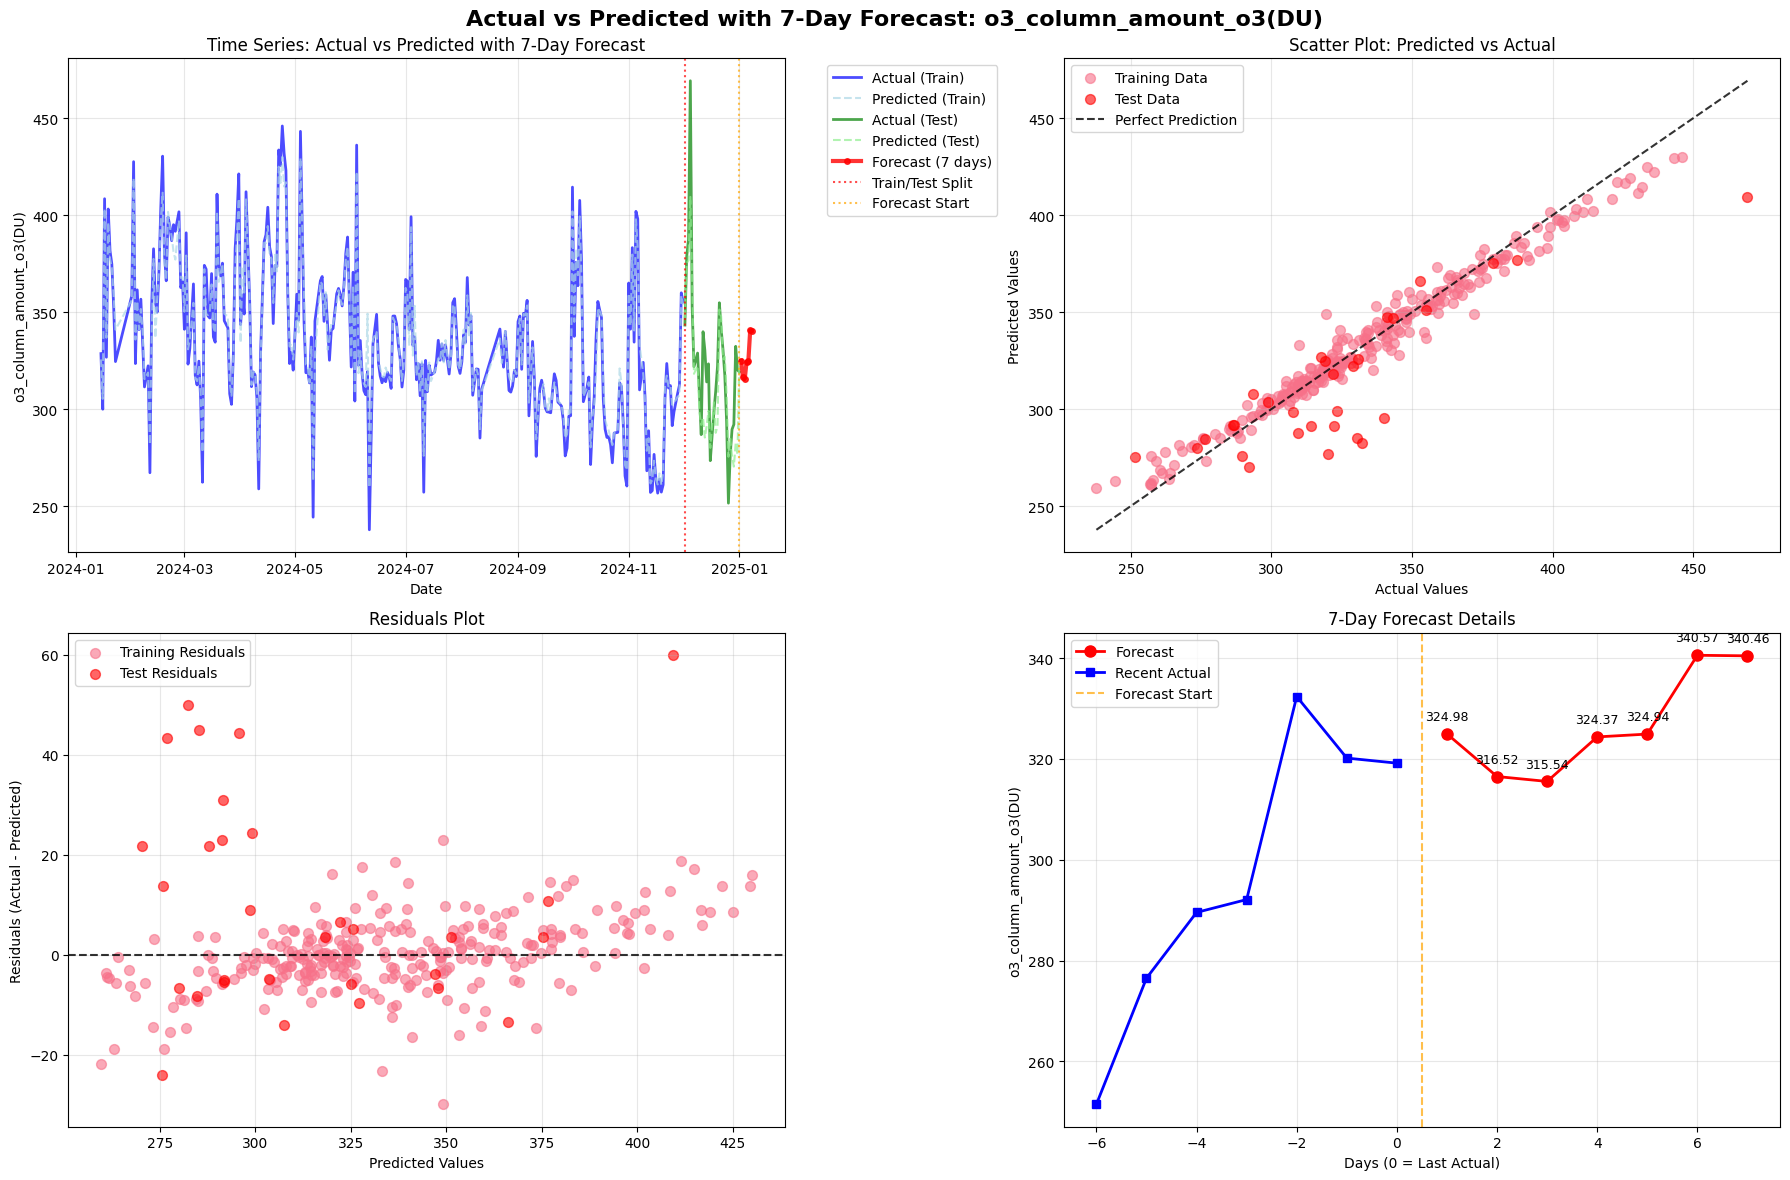


📊 MODEL PERFORMANCE FOR o3_column_amount_o3(DU):
Training Set:
  MAE:  5.2042
  R²:   0.9675
Test Set (Last 30 days):
  MAE:  17.5859
  R²:   0.6525

🔮 7-DAY FORECAST FOR o3_column_amount_o3(DU):
----------------------------------------
  2025-01-02 Thursday: 324.9768
  2025-01-03 Friday: 316.5156
  2025-01-04 Saturday: 315.5414
  2025-01-05 Sunday: 324.3743
  2025-01-06 Monday: 324.9361
  2025-01-07 Tuesday: 340.5687
  2025-01-08 Wednesday: 340.4609

 ANALYZING: no2_vertical_column_total(molecules/cm2)
--------------------------------------------------
  Creating features for 329 days of data...
  Feature creation complete: 329 → 315 samples
  Total features: 96


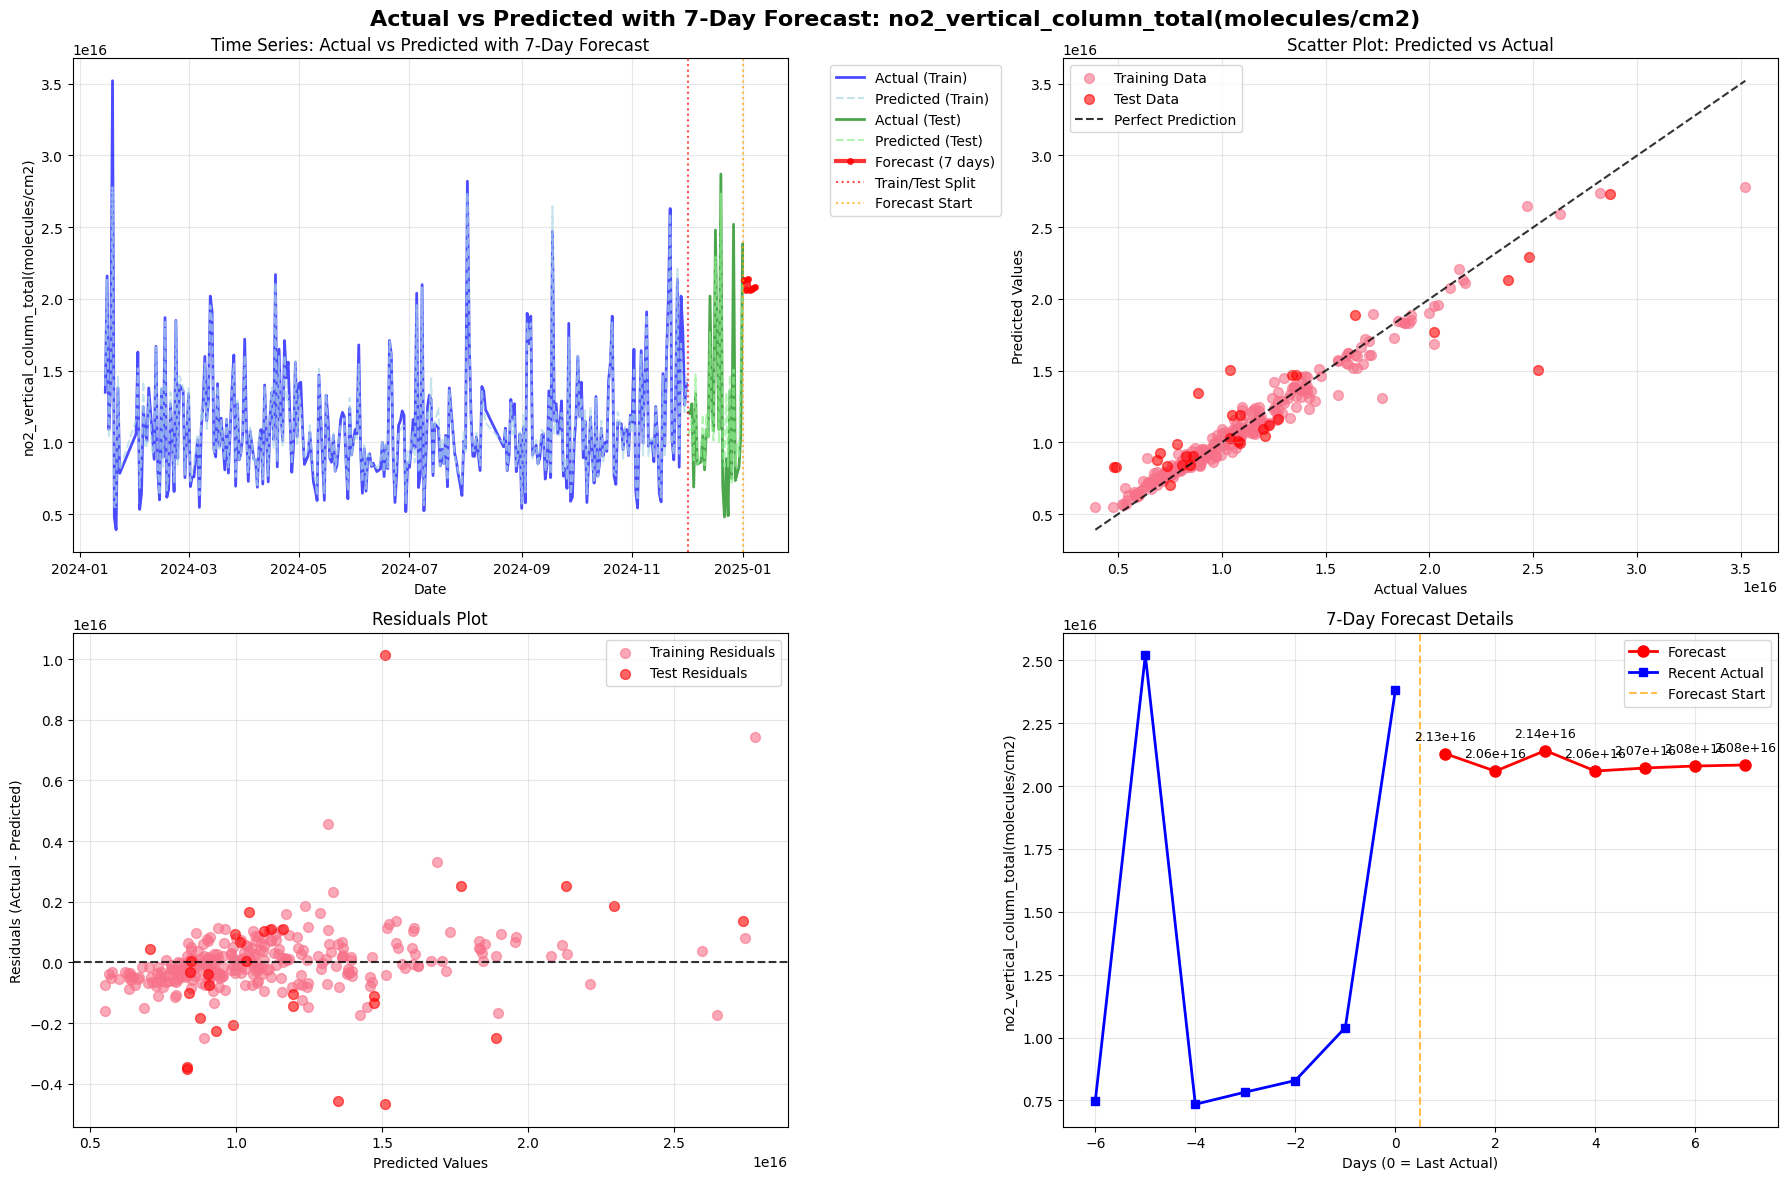


📊 MODEL PERFORMANCE FOR no2_vertical_column_total(molecules/cm2):
Training Set:
  MAE:  548439182013116.8750
  R²:   0.9585
Test Set (Last 30 days):
  MAE:  1922504995812833.5000
  R²:   0.8037

🔮 7-DAY FORECAST FOR no2_vertical_column_total(molecules/cm2):
----------------------------------------
  2025-01-02 Thursday: 2.1288e+16
  2025-01-03 Friday: 2.0591e+16
  2025-01-04 Saturday: 2.1412e+16
  2025-01-05 Sunday: 2.0597e+16
  2025-01-06 Monday: 2.0719e+16
  2025-01-07 Tuesday: 2.0797e+16
  2025-01-08 Wednesday: 2.0838e+16

 ANALYZING: vertical_column(molecules/cm2)
--------------------------------------------------
  Creating features for 329 days of data...
  Feature creation complete: 329 → 315 samples
  Total features: 96


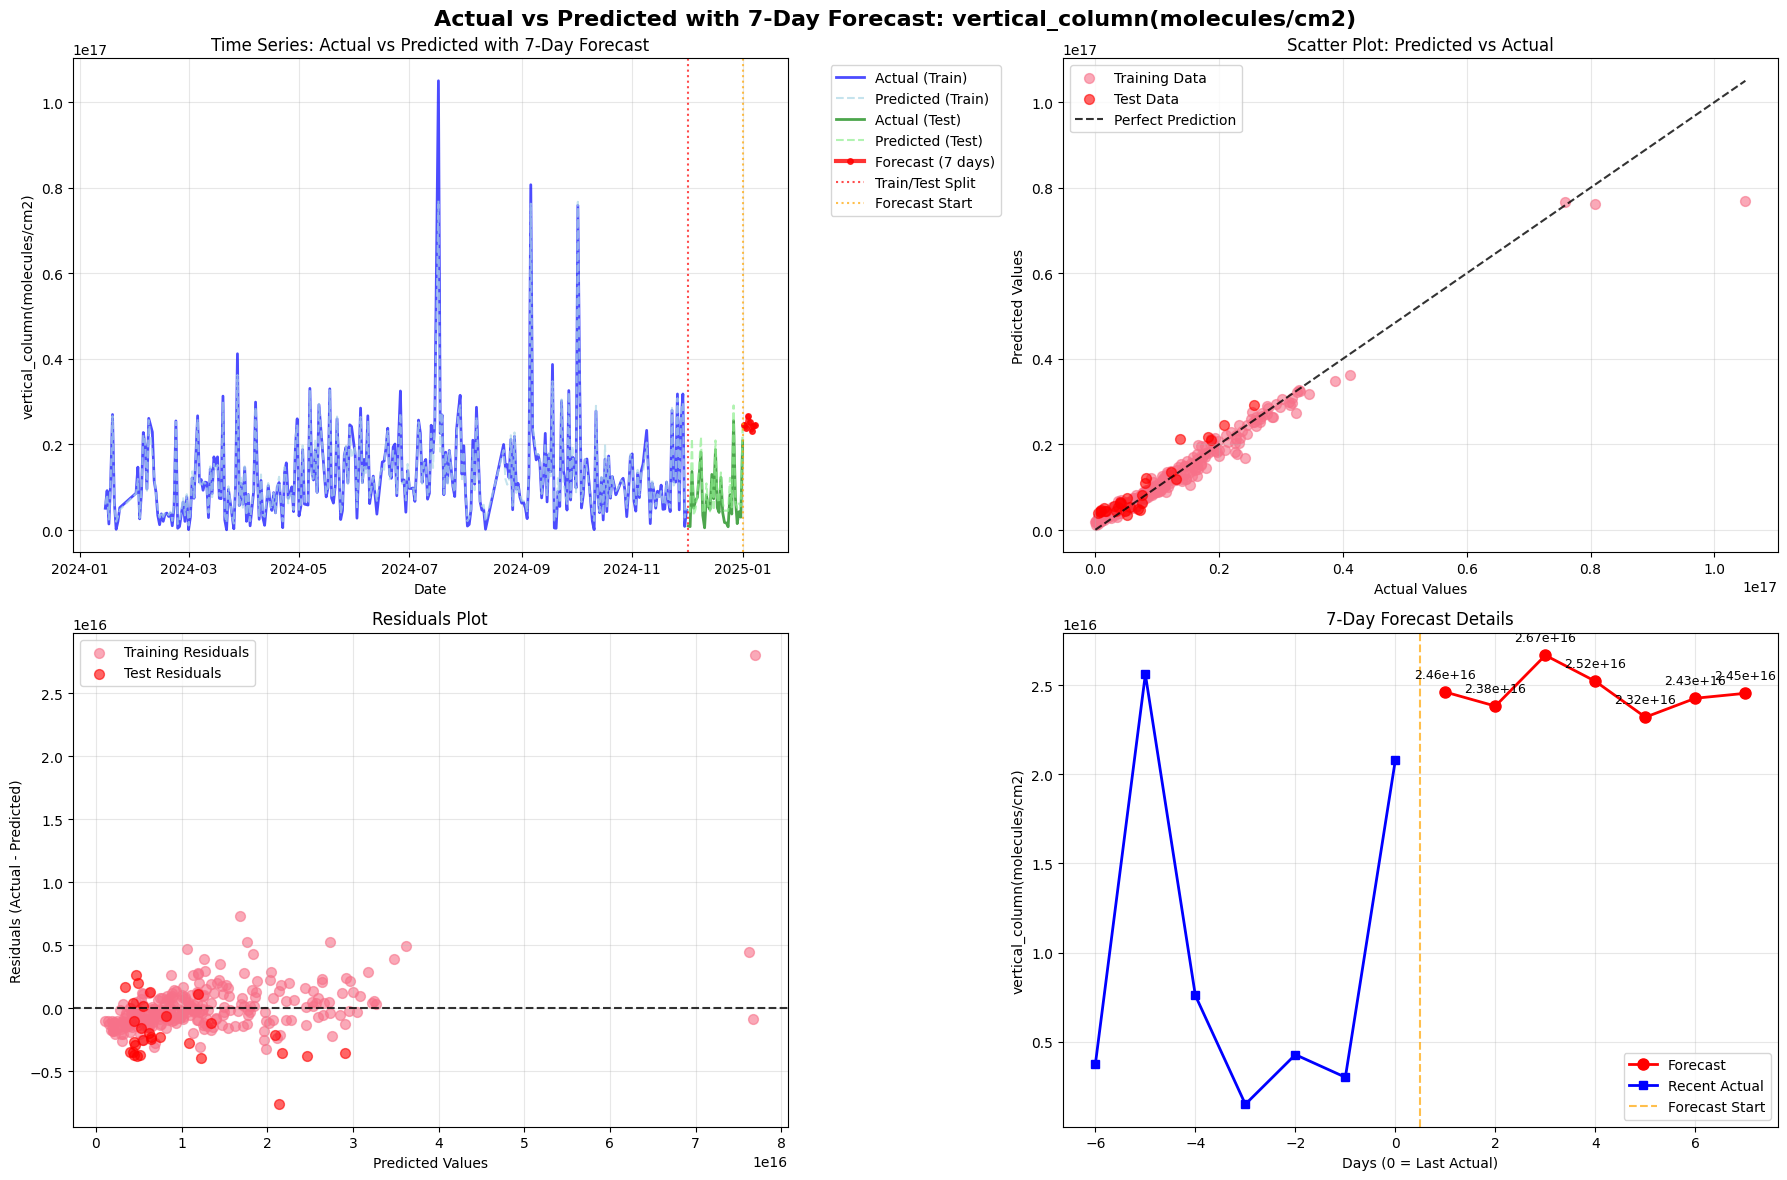


📊 MODEL PERFORMANCE FOR vertical_column(molecules/cm2):
Training Set:
  MAE:  1226605738691053.0000
  R²:   0.9616
Test Set (Last 30 days):
  MAE:  2541624189183207.0000
  R²:   0.7920

🔮 7-DAY FORECAST FOR vertical_column(molecules/cm2):
----------------------------------------
  2025-01-02 Thursday: 2.4606e+16
  2025-01-03 Friday: 2.3820e+16
  2025-01-04 Saturday: 2.6668e+16
  2025-01-05 Sunday: 2.5210e+16
  2025-01-06 Monday: 2.3198e+16
  2025-01-07 Tuesday: 2.4260e+16
  2025-01-08 Wednesday: 2.4537e+16

 7-DAY FORECAST COMPARISON


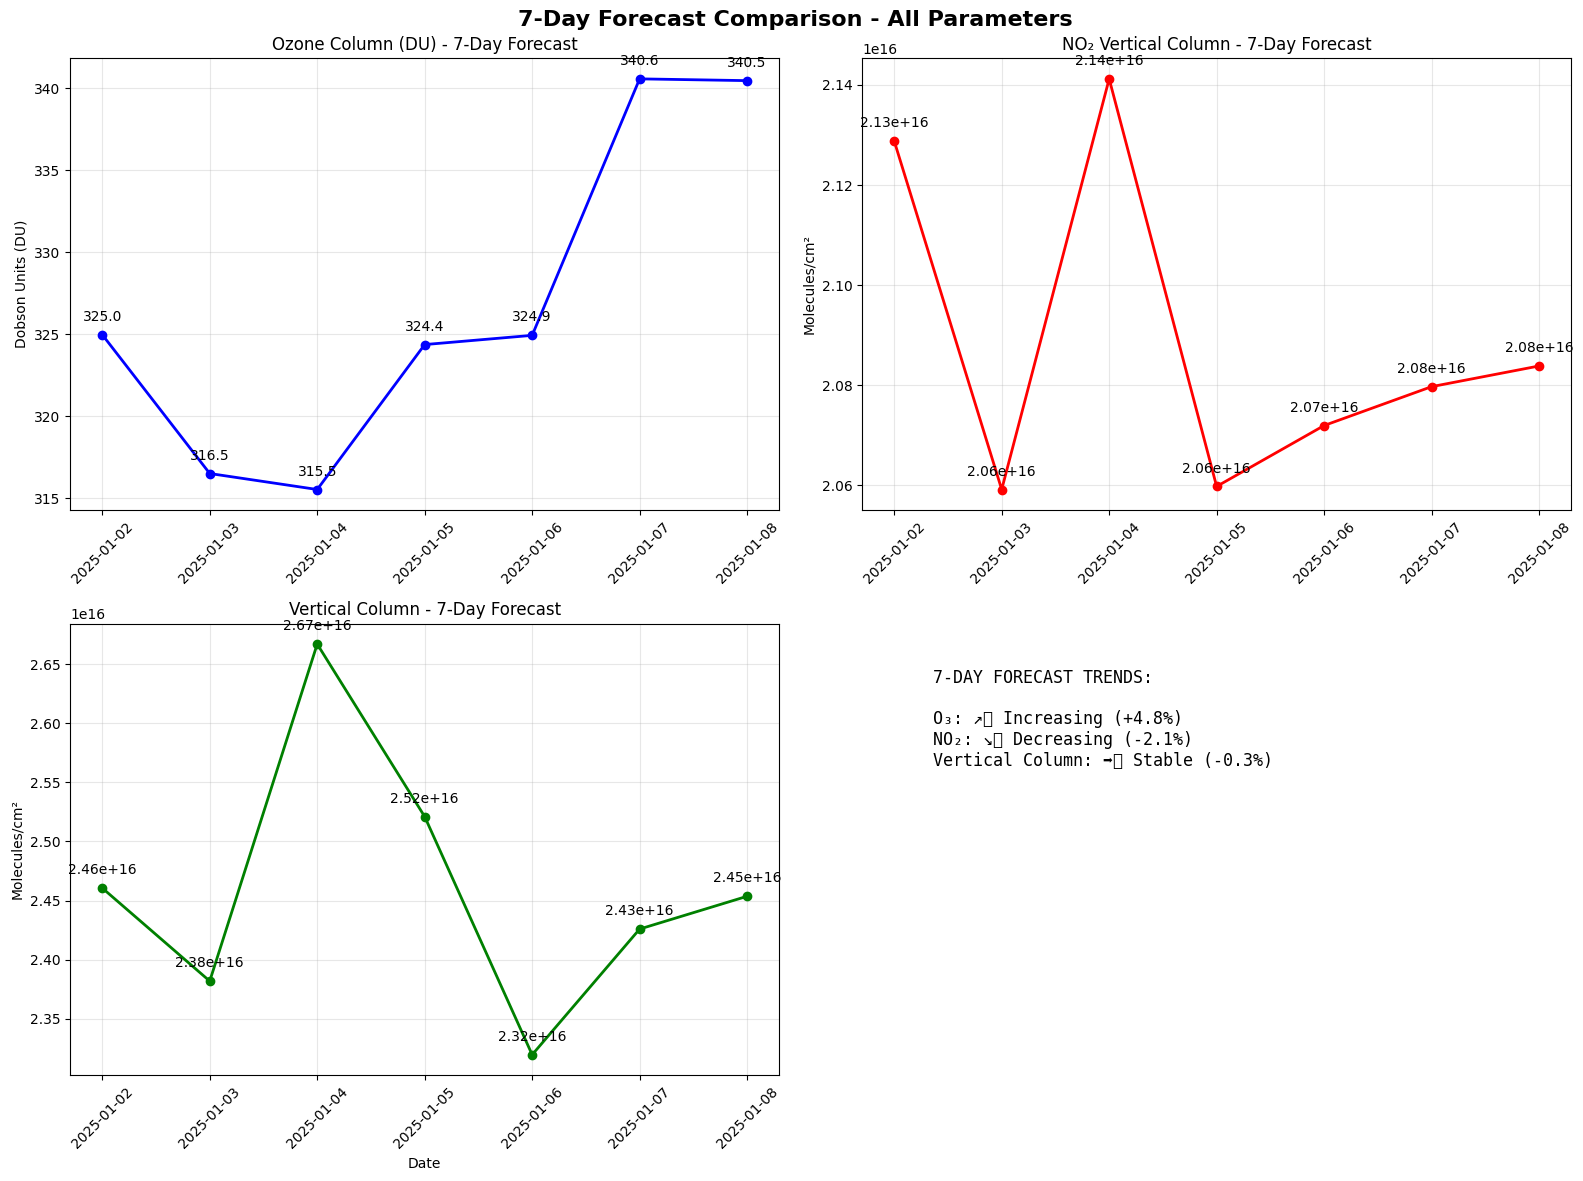


OVERALL MODEL PERFORMANCE SUMMARY

o3_column_amount_o3(DU):
  Training R²:   0.9675
  Test R²:       0.6525
  Training MAE:  5.2042
  Test MAE:      17.5859
  Interpretation: Good predictive power

no2_vertical_column_total(molecules/cm2):
  Training R²:   0.9585
  Test R²:       0.8037
  Training MAE:  548439182013116.8750
  Test MAE:      1922504995812833.5000
  Interpretation: Excellent predictive power

vertical_column(molecules/cm2):
  Training R²:   0.9616
  Test R²:       0.7920
  Training MAE:  1226605738691053.0000
  Test MAE:      2541624189183207.0000
  Interpretation: Excellent predictive power


In [37]:

print(" CREATING ACTUAL VS PREDICTED ANALYSIS WITH 7-DAY FORECASTS")
print("="*70)

# Plot for each parameter
performance_metrics = {}
all_forecasts = {}
all_forecast_dates = None

for target_col in ['o3_column_amount_o3(DU)', 'no2_vertical_column_total(molecules/cm2)', 'vertical_column(molecules/cm2)']:
    print(f"\n ANALYZING: {target_col}")
    print("-" * 50)

    fig, metrics, forecasts, forecast_dates = plot_actual_vs_predicted_with_forecast(df, target_col, forecast_days=7)
    performance_metrics[target_col] = metrics
    all_forecasts[target_col] = forecasts
    all_forecast_dates = forecast_dates  # All should be the same

    plt.show()

# Create comparison plot
print("\n" + "="*70)
print(" 7-DAY FORECAST COMPARISON")
print("="*70)
create_forecast_comparison_plot(all_forecasts, all_forecast_dates)

# Performance summary
print("\n" + "="*70)
print("OVERALL MODEL PERFORMANCE SUMMARY")
print("="*70)

for target_col, (train_mae, test_mae, train_r2, test_r2) in performance_metrics.items():
    print(f"\n{target_col}:")
    print(f"  Training R²:   {train_r2:.4f}")
    print(f"  Test R²:       {test_r2:.4f}")
    print(f"  Training MAE:  {train_mae:.4f}")
    print(f"  Test MAE:      {test_mae:.4f}")

    # Interpretation
    if test_r2 > 0.7:
        interpretation = "Excellent predictive power"
    elif test_r2 > 0.5:
        interpretation = "Good predictive power"
    elif test_r2 > 0.3:
        interpretation = "Moderate predictive power"
    else:
        interpretation = "Limited predictive power"

    print(f"  Interpretation: {interpretation}")
